# Perfume Segmentation K-Means

## Setup Database

In [92]:
# Import libraries
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

load_dotenv()

True

In [93]:
# Read database configuration from environment variables
database_config = {
  'engine': os.getenv('DB_ENGINE'),
  'host': os.getenv('DB_HOST'),
  'port': os.getenv('DB_PORT'),
  'username': os.getenv('DB_USERNAME'),
  'pass': os.getenv('DB_PASS'),
  'database': os.getenv('DB_NAME')
}

In [94]:
# Create a connection to the database
connection_str = f"{database_config['engine']}://{database_config['username']}:{database_config['pass']}@{database_config['host']}:{database_config['port']}/{database_config['database']}"
print("Connection String:", connection_str)  # Debug the connection string
engine = create_engine(connection_str)

Connection String: mysql://root:@10.93.123.133:3306/perfume_segmentation


In [95]:
# Load perfumes table
query = """
SELECT
    s.id,
    s.age,
    s.gender,
    s.profession_id,
    s.perfume_id,
    p.name AS perfume_name,
    pr.name AS profession_name
FROM sales AS s
LEFT JOIN perfumes AS p ON s.perfume_id = p.id
LEFT JOIN professions AS pr ON s.profession_id = pr.id
"""
df_sales = pd.read_sql(query, engine)

df_sales.head()


,id,age,gender,profession_id,perfume_id,perfume_name,profession_name
0,1,54,0,0,0,Bacarat,Ibu Rumah Tangga
1,2,49,0,0,1,D&G,Ibu Rumah Tangga
2,3,26,0,1,2,Paris Hilton,Pegawai Negeri
3,4,40,0,2,1,D&G,Karyawan
4,5,52,0,2,0,Bacarat,Karyawan


## K-Means

In [96]:
from sklearn.cluster import KMeans

In [97]:
# Select features from the DataFrame
X = df_sales[['age', 'gender', 'profession_id', 'perfume_id']].copy()

# Specify the sales IDs to use as initial centroids
initial_centroid_ids = [5, 10, 15, 20, 25]

# Extract the rows with these sales IDs to obtain the initial centroids
# Make sure that the 'id' column corresponds to your sales id
initial_centroids = df_sales[df_sales['id'].isin(initial_centroid_ids)][['age', 'gender', 'profession_id', 'perfume_id']].values

# Initialize KMeans with the predefined centroids
k = 5  # Total number of clusters
kmeans = KMeans(n_clusters=k, init=initial_centroids, n_init=1, max_iter=1)

# Train the KMeans model on the selected features
kmeans.fit(X)

# Retrieve the cluster labels and add them to the DataFrame
labels = kmeans.labels_
df_sales['cluster'] = labels


In [98]:
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Get cluster labels
df_sales_with_labels = df_sales.groupby('cluster').agg({
    'age': 'mean',
    'perfume_id': 'mean',
    'gender': 'mean',
    'profession_id': 'mean',
})

print(df_sales_with_labels)
print(df_sales_with_labels.round(0).astype(int))

               age  perfume_id    gender  profession_id
cluster                                                
0        51.380952    1.428571  0.142857       1.285714
1        57.600000    1.450000  0.400000       2.400000
2        20.071429    1.660714  0.517857       3.196429
3        44.291667    1.708333  0.500000       1.583333
4        33.725000    1.500000  0.425000       2.000000
         age  perfume_id  gender  profession_id
cluster                                        
0         51           1       0              1
1         58           1       0              2
2         20           2       1              3
3         44           2       0              2
4         34           2       0              2


In [99]:
# Get luster labels rounded to the nearest integer
df_sales_with_labels = df_sales_with_labels.round(0).astype(int)

df_sales_with_labels['perfume_name'] = df_sales.groupby('cluster')['perfume_name'].agg(lambda x: x.mode()[0])
df_sales_with_labels['profession_name'] = df_sales.groupby('cluster')['profession_name'].agg(lambda x: x.mode()[0])


# Display the cluster centroids
df_sales_with_labels

,age,perfume_id,gender,profession_id,perfume_name,profession_name
cluster,,,,,,
0,51,1,0,1,D&G,Ibu Rumah Tangga
1,58,1,0,2,D&G,Karyawan
2,20,2,1,3,Bacarat,Pelajar
3,44,2,0,2,D&G,Pegawai Negeri
4,34,2,0,2,Bacarat,Pegawai Negeri


## Visualization

In [100]:
import matplotlib.pyplot as plt


<Figure size 1000x600 with 0 Axes>

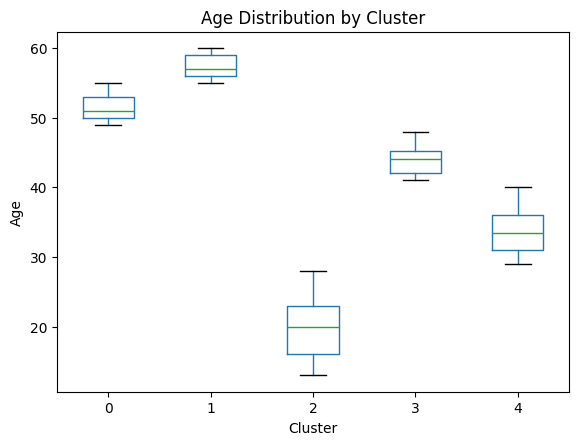

In [101]:
plt.figure(figsize=(10, 6))
df_sales.boxplot(column='age', by='cluster', grid=False)
plt.xlabel('Cluster')
plt.ylabel('Age')
plt.title('Age Distribution by Cluster')
plt.suptitle('')  # Remove default subtitle
plt.show()

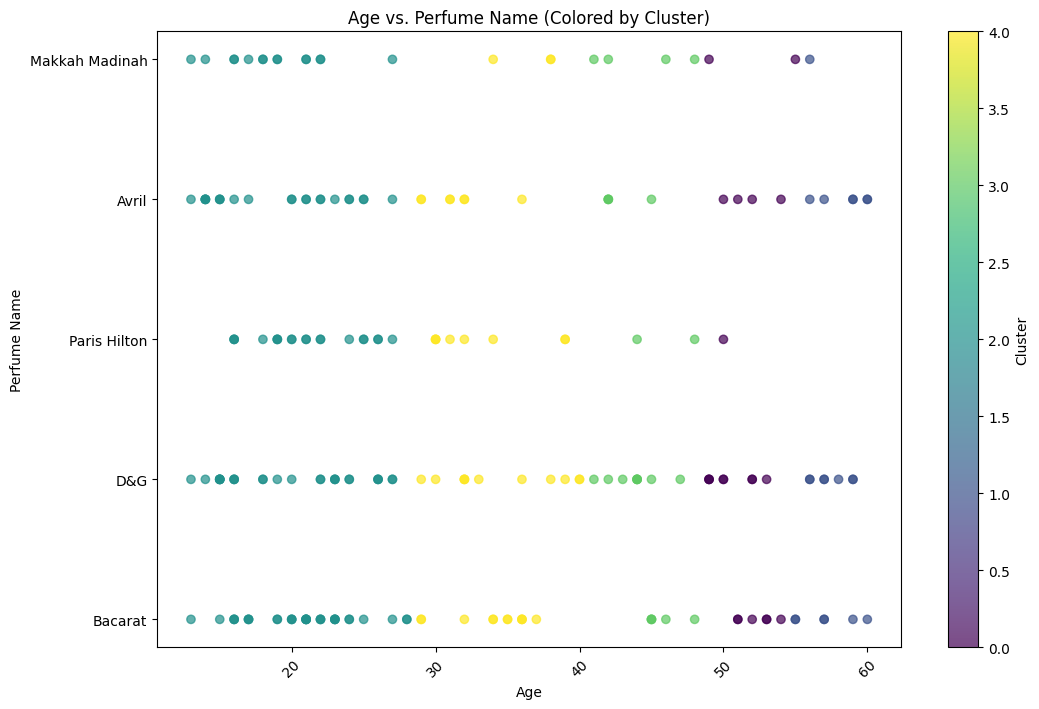

In [102]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    df_sales['age'],
    df_sales['perfume_name'],
    c=df_sales['cluster'],
    cmap='viridis',
    alpha=0.7
)
plt.xlabel('Age')
plt.ylabel('Perfume Name')
plt.title('Age vs. Perfume Name (Colored by Cluster)')
plt.colorbar(scatter, label='Cluster')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()